## CNN implement by numpy

Reference blog: 
- [Building Convolutional Neural Network using NumPy from Scratch](https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a) 
- [Convolutional Neural Networks from the ground up](https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1)

In [161]:
import numpy as np
import pandas as ps
import sklearn 
import skimage
import tensorflow.keras.datasets as datasets
from sklearn.utils import shuffle

## Training Data
- use MNIST dataset

In [5]:
img = skimage.data.chelsea()
img = skimage.color.rgb2gray(img)

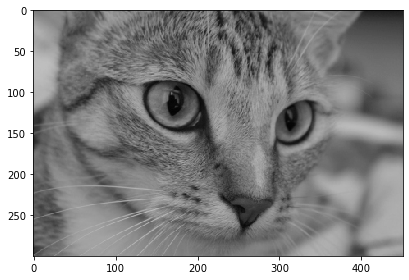

In [6]:
skimage.io.imshow(img)

In [7]:
(x_train, y_train), (x_test, y_test)=datasets.mnist.load_data(path="mnist.npz")

In [8]:
y_train.shape

(60000,)

## Build Model
- Build a basic CNN model with an **input layer**, a **cnn layer**, a **downsample layer** and a **dense layer** model
- use zero-padding

- filter in shape (number_of_filter, number_of_color, filter_x, filter_y)
- image in shape **[number_of_color, image_x, image_y]** (remember in Keras model, training data(image) formed in shape **[number_of_images,image_x, image_y, number_of_color]**)

- loss function for cross entropy:

$$ H(y,y^{hat}) = \sum_i y_i log \frac{1}{y_i^{hat}} = - \sum_i y_i log y_i^{hat}  $$

- back propagation \
blogs: \
 [Convolutions and Backpropagations](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c) \
we can also apply chain role to convolution layer \

for **convolution layer**, we have filter as `F` and input data(image) is `x`, Conv(X,F) we can get the output `O` and final Loss `L`: 

$$ \frac{\alpha L}{\alpha F} = Conv (x, \frac{\alpha L}{\alpha O})$$
$$ \frac{\alpha L}{\alpha x} = Conv (180^o rotated F, \frac{\alpha L}{\alpha O})$$

We need to update parameters `W`,`b` and `kernel_filter`

In [213]:
class cnn():

    ## input size is a tuple=(n_color, input_x, input_y)
    def __init__(self,input_size,kernel_size,n_filters,output_size=1,stride=1):
        ## parameters in input layer
        self.input_size = input_size
        self.n_c = input_size[0]
        self.img_x = input_size[1]
        self.img_y = input_size[2]
        
        ## parameters in cnn layer
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.filter = np.random.uniform(size=(self.n_filters,self.n_c,self.kernel_size,self.kernel_size))
        self.bias = np.random.uniform(size=(self.n_filters))
        self.output_size = output_size
        self.stride = stride

        
        ## parameters in dense layer
        out_dim_x = int((input_size[1] - kernel_size+2)/stride) + 1
        out_dim_y = int((input_size[2] - kernel_size+2)/stride) + 1
        n_flatten_size = n_filters*input_size[0]*(int(out_dim_x/2) +int(out_dim_x%2))*(int(out_dim_y/2) +int(out_dim_y%2))
        self.W = np.random.uniform(-1,1,size = (n_flatten_size,output_size))
        self.b = np.random.uniform(size = (output_size,1))
        
    def forward_propagation(self,x):
        cnn_out = Relu(self.convolution(x,self.filter,stride=self.stride))
        max_pool_out = self.maxpool(cnn_out)
        flatten_out = self.flatten(max_pool_out)
        output = self.W.T.dot(flatten_out)+self.b
    
        return softmax(output)
    
    def back_propagation(self,y):
        pass
        

    def forward_backward_propagation(self,x,y):
        cnn_out = Relu(self.convolution(x,self.filter,stride=self.stride))
        max_pool_out = self.maxpool(cnn_out)
        flatten_out = self.flatten(max_pool_out)
        output = self.W.T.dot(flatten_out)+self.b
        y_out = softmax(output)
        
        loss = self.calculate_total_loss(y,y_out)
        
        dout = y_out - np.array(y).reshape(self.output_size,-1)

        dW = dout.dot(flatten_out.T)
        db = np.sum(dout,axis=1).reshape(self.b.shape)
        
        dflatten_out = self.W.dot(dout)
        dpool = dflatten_out.reshape(max_pool_out.shape)
        
        dconv = maxpoolBackward(dpool,cnn_out,2,2)
        dconv[cnn_out<0]=0
        
        dimage,dfilter,dbias = convolutionBackward(dconv,x,self.filter,self.stride)
        
        grads = [dfilter,dbias, dW, db]
        
        return grads,loss
    
    
    ## adamGD gradient algorithm   
    ## train one batch of data, update parameters
    # x_batch in shape (number_of_data, n_color, dim_x, dim_y) , y_batch is the label of data
    # parameters for AdamGD: lr, beta1, beta2
    def adamGD(self, x_batch, y_batch, lr, beta1, beta2, cost):
  
        num_classes = self.output_size

        X = x_batch # get batch inputs
        Y = y_batch # get batch labels

        cost_ = 0
        batch_size = len(x_batch)

        # initialize gradients and momentum,RMS params
        dfilter = np.zeros(self.filter.shape)
#        df2 = np.zeros(f2.shape)
        dW = np.zeros(self.W.shape)
#        dw4 = np.zeros(w4.shape)
        db = np.zeros(self.b.shape)
#        db2 = np.zeros(b2.shape)
        dbias = np.zeros(self.bias.shape)
#        db4 = np.zeros(b4.shape)

        vfilter = np.zeros(self.filter.shape)
#        v2 = np.zeros(f2.shape)
        vW = np.zeros(self.W.shape)
#        v4 = np.zeros(w4.shape)
        vbias = np.zeros(self.bias.shape)
#        bv2 = np.zeros(b2.shape)
        vb = np.zeros(self.b.shape)
#        bv4 = np.zeros(b4.shape)

        sfilter = np.zeros(self.filter.shape)
#        s2 = np.zeros(f2.shape)
        sW = np.zeros(self.W.shape)
#        s4 = np.zeros(w4.shape)
        sbias = np.zeros(self.bias.shape)
#        bs2 = np.zeros(b2.shape)
        sb = np.zeros(self.b.shape)
#        bs4 = np.zeros(b4.shape)

        for i in range(0,batch_size):

            x = X[i]
            y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot

            # Collect Gradients for training example
            grads, loss = self.forward_backward_propagation(x, y)
            [dfilter_,dbias_, dW_, db_] = grads

            dfilter+=dfilter_
            dbias+=dbias_.reshape(-1)
            dW+=dW_.T
            db+=db_

            cost_+= loss

        # Parameter Update  

        vfilter = beta1*vfilter + (1-beta1)*dfilter/batch_size # momentum update
        sfilter = beta2*sfilter + (1-beta2)*(dfilter/batch_size)**2 # RMSProp update
        self.filter -= lr * vfilter/np.sqrt(sfilter+1e-7) # combine momentum and RMSProp to perform update with Adam

        vbias = beta1*vbias + (1-beta1)*dbias/batch_size
        sbias = beta2*sbias + (1-beta2)*(dbias/batch_size)**2
        self.bias -= lr * vbias/np.sqrt(sbias+1e-7)

  
        vW = beta1*vW + (1-beta1) * dW/batch_size
        sW = beta2*sW + (1-beta2)*(dW/batch_size)**2
        self.W -= lr * vW/np.sqrt(sW+1e-7)

        vb = beta1*vb + (1-beta1) * db/batch_size
        sb = beta2*sb + (1-beta2)*(db/batch_size)**2
        self.b -= lr * vb/np.sqrt(sb+1e-7)

        cost_ = cost_/batch_size
        cost.append(cost_)

        #params = [self.filter,self.bias, self.W, self.b]

        return  cost

    #####################################################
    ##################### Training ######################
    #####################################################

    def train(self, x , y, lr=0.005, beta1 = 0.95, beta2 = 0.99, batch_size = 32, num_epochs = 2, save_path = 'params.pkl'):

        # Get training data
#        x,y = shuffle(x,y, random_state = 41)
        m =50000

        ## Initializing all the parameters
        num_class = self.output_size

        cost = []

        print("LR:"+str(lr)+", Batch Size:"+str(batch_size))

        for epoch in range(num_epochs):
            x,y = shuffle(x,y)
            x_batches = [x[k:k + batch_size] for k in range(0, x.shape[0], batch_size)]
            y_batches = [y[k:k + batch_size] for k in range(0, y.shape[0], batch_size)]
    
            for i in range(0,len(x_batches)):
                cost = []
                x_batch = x_batches[i]
                y_batch = y_batches[i]
                cost = self.adamGD(x_batch, y_batch,  lr, beta1, beta2 , cost)
                print("Cost: %.2f" % (cost[-1]))
            
            print('final cost in this epoch: ',np.mean(cost))

        if save_path:
            with open(save_path, 'wb') as file:
                pickle.dump(params, file)

        return cost

    def predict(self,x):
        output = []
        for i in range(0,len(x)):
            y_onehot= self.forward_propagation(x[i].reshape(self.n_c,self.img_x,self.img_y))
            output.append(y_onehot)
        return np.argmax(output,axis=1)
        

    ## cross entropy
    def calculate_total_loss(self,y,y_hat):
        return -np.sum(y*np.log(y_hat+1e-15))
        

    ## do convolution for a single image and output the result 
    def convolution(self,image,kernel_filter,stride=1):
        
        ## claculate the input and output dimension and make sure they match
        (n_f,n_c_f,f_x,f_y ) = kernel_filter.shape
        (n_c,img_x,img_y) = image.shape
        
        out_dim_x = int((img_x - f_x+2)/stride) + 1
        out_dim_y = int((img_y - f_y+2)/stride) + 1       
        
        assert n_c == n_c_f
        
        ## zero-padding
        Image = np.zeros((img_x+2,img_y+2))
        Image[1:img_x+1,1:img_y+1] = image 
        
        ## calculate output
        out = np.zeros((n_f,out_dim_x,out_dim_y))
        
        for i,curr_f in enumerate(kernel_filter):
            curr_out = np.zeros((out_dim_x,out_dim_y))
            for out_x in range(0,out_dim_x):
                for out_y in range(0,out_dim_y):
                    image_here = Image[out_x*stride:out_x*stride+f_x, out_y*stride:out_y*stride+f_y]
                    curr_out[out_x,out_y] = np.sum(curr_f * image_here)
                    
            out[i] = curr_out + self.bias[i]
        
        
        return out
    
    ## strik image to 1/4 by combine each four pix to the max one
    def maxpool(self,image):
        (n_c,img_x,img_y) = image.shape
        out = np.zeros((n_c, int(img_x/2)+ int(img_x%2),int(img_y/2)+ int(img_y%2)))
        for current_c in range(0,n_c):
            for i in range(0,out.shape[1]):
                for j in range(0,out.shape[2]):
                    if (i+1 < out.shape[1]) and (j+1 < out.shape[2]):
                        out[current_c,i,j] = np.max(image[current_c,2*i:2*i+2,2*j:2*j+2])
                    elif (i+1 == out.shape[1]) and (j+1) == out.shape[2]:
                        out[current_c,i,j] = image[current_c,2*i,2*j]
                    elif (i+1 < out.shape[1]) and (j+1) == out.shape[2]:
                        out[current_c,i,j] = np.max(image[current_c,2*i:2*i+2,2*j])
                    elif (i+1 == out.shape[1]) and (j+1) < out.shape[2]:
                        out[current_c,i,j] = np.max(image[current_c,2*i,2*j:2*j+2])                    
                  
        return out
    
    
    def flatten(self,x):
        return x.reshape(-1,1)
    
    

def softmax(raw_preds):
    
    preds = raw_preds-np.max(raw_preds)
    out = np.exp(preds) # exponentiate vector of raw predictions
    return out/np.sum(out) # divide the exponentiated vector by its sum. All values in the output sum to 1.
    
    
def Relu(x):
    return np.maximum(0,x)
        
    
## in the backpropagation of cov layer, 
## we use filter(f/filt) and input data(x/conv_in), difference of output(dconv_prev --> could be an output of  packprop from the frontier layer 
## as the input of deconv calculation
## we use difference of filter(dfilt), difference of the bias(dbias), difference of the out(dout) as the output
def convolutionBackward(dconv_prev, conv_in, filt, s):
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim_x, orig_dim_y) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim_y:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim_x:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_x, out_y] * conv_in[:, curr_x:curr_x+f, curr_y:curr_y+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_x:curr_x+f, curr_y:curr_y+f] += dconv_prev[curr_f, out_x, out_y] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

def nanargmax(arr):

##    return index of the largest non-nan value in the array. Output is an ordered pair tuple

    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 


## in the backpropagation of maxpool layer
##
def maxpoolBackward(dpool, orig, f, s):
##    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.

    (n_c, orig_dim_x, orig_dim_y) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim_y:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim_x:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_x:curr_x+f, curr_y:curr_y+f])
                dout[curr_c, curr_x+a, curr_y+b] = dpool[curr_c, out_x, out_y]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout        

def DenseBackward():
    pass

In [214]:
model= cnn(input_size=(1,28,28),kernel_size=3,n_filters=10,output_size=10)

In [186]:
model.train(x_train.reshape(-1,1,28,28) , np.array(y_train), beta1 = 0.95, beta2 = 0.99, batch_size = 32, num_epochs = 2, save_path = False)

LR:0.005, Batch Size:32
Cost: 30.22
Cost: 30.22
Cost: 30.22
Cost: 31.30
Cost: 29.14
Cost: 26.98
Cost: 28.06
Cost: 24.82
Cost: 29.14
Cost: 28.06
Cost: 31.30
Cost: 31.10
Cost: 29.14
Cost: 25.90
Cost: 26.98
Cost: 24.82
Cost: 26.98
Cost: 29.14
Cost: 30.22
Cost: 23.75
Cost: 24.82
Cost: 29.14
Cost: 26.98
Cost: 25.90
Cost: 22.67
Cost: 23.75
Cost: 22.67
Cost: 26.98
Cost: 22.72
Cost: 23.75
Cost: 23.75
Cost: 23.75
Cost: 18.35
Cost: 26.98
Cost: 18.10
Cost: 28.06
Cost: 28.06
Cost: 22.67
Cost: 21.59
Cost: 21.59
Cost: 24.82
Cost: 20.51
Cost: 18.35
Cost: 16.19
Cost: 23.75
Cost: 26.98
Cost: 18.28
Cost: 19.43
Cost: 21.59
Cost: 21.59
Cost: 15.11
Cost: 21.59
Cost: 20.51
Cost: 19.43
Cost: 17.27
Cost: 19.58
Cost: 16.19
Cost: 20.51
Cost: 21.59
Cost: 17.27
Cost: 21.59
Cost: 20.51
Cost: 15.11
Cost: 17.27
Cost: 20.96
Cost: 12.95
Cost: 17.27
Cost: 16.19
Cost: 20.51
Cost: 11.87
Cost: 17.27
Cost: 15.11
Cost: 17.27
Cost: 19.43
Cost: 12.95
Cost: 18.35
Cost: 16.19
Cost: 11.87
Cost: 16.19
Cost: 17.27
Cost: 7.56
Cost:

KeyboardInterrupt: 

In [215]:
model.predict(x_train[3:20].reshape(-1,1,28,28))

array([[5],
       [6],
       [5],
       [6],
       [5],
       [6],
       [6],
       [5],
       [7],
       [5],
       [6],
       [3],
       [5],
       [5],
       [5],
       [6],
       [6]], dtype=int64)